In [1]:
import numpy as np
import torch
from scipy.optimize import minimize
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
from tqdm import tqdm
from time import time

In [2]:
print('PyTorch version', torch.__version__)
if torch.cuda.is_available():
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
  print('Use ***GPU***')
  print(torch.cuda.get_device_properties(0).total_memory/1024/1024/1024,'GB')
else:
  print('Use CPU')
  torch.set_default_tensor_type('torch.FloatTensor')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch version 1.7.0
Use ***GPU***
31.74853515625 GB


In [3]:
""" Generate synthetic data """
np.random.seed(2022)

N = 50000
d = 100
mu = np.random.uniform(5,10, d)
Sig_factor = np.random.uniform(0,1, (d,20))
Sigma = Sig_factor.dot(Sig_factor.T)+np.eye(d)
X = np.random.multivariate_normal(mu, Sigma, N)

# Truncate
percentile = -0.383 # 0.675 => remove 25%, 0.0 => remove 0.5%, -0.675=> remove 75%
std = np.sqrt(np.diag(Sigma))
cond_lower = mu + percentile*std
cond_upper = [10000.0]*d
for i in range(X.shape[1]):
  X[np.logical_and(X[:,i]>cond_lower[i], X[:,i]<cond_upper[i]),i] = np.nan
X[:20,:]

array([[       nan, 3.69936727,        nan, ..., 3.73016296, 0.72552897,
               nan],
       [       nan,        nan,        nan, ..., 4.09845224, 3.98666281,
        1.4010849 ],
       [1.4172262 , 4.55975095,        nan, ..., 1.45969442, 0.21816242,
        1.10356968],
       ...,
       [       nan,        nan,        nan, ...,        nan, 3.33037147,
               nan],
       [       nan, 6.00709234,        nan, ..., 1.33762049,        nan,
               nan],
       [       nan, 5.47661132,        nan, ..., 2.78265456,        nan,
        3.35730083]])

In [5]:
class MeanEst():
  def __init__(self):
    self.affine_transform = True

  def PairwiseEmp(self, X, pair_idx, M, batch_size):
    mu_hatS_lst = []
    Sig_hatS_lst = []
    O_aff_lst = []
    rand_sample_idx = []
    n_lst = []
    for i in range(X.shape[1]):
      O = X[pair_idx[str(i)],:][:,[i]]

      mu_hatS = torch.mean(O,axis=0)
      X_pair = O - mu_hatS
      n, d = X_pair.shape[0], 1
      A = X_pair.reshape(n,d,1)
      B = torch.transpose(A, dim0=2, dim1=1)
      # Sig_hatS = torch.mean(torch.einsum('ijk,ikd->ijd', A, B),axis=0)
      Sig_hatS = torch.mean(torch.matmul(A, B),axis=0)

      if self.affine_transform==True:
        O_aff = (1/torch.sqrt(Sig_hatS)).matmul(X_pair.t()).t()
      else:
        O_aff = O

      mu_hatS_lst.append(mu_hatS.reshape(-1,1))
      Sig_hatS_lst.append(Sig_hatS)
      O_aff_lst.append(O_aff)
      rand_sample_idx.append(np.random.choice(range(0,n), (M,batch_size)))
      n_lst.append(n)

    n_max = np.max(n_lst)

    for i in range(len(O_aff_lst)):
      n = n_lst[i]
      nan_tensor = torch.zeros((n_max-n,1))
      nan_tensor[:,:] = float('nan')
      O_aff_lst[i] = torch.cat((O_aff_lst[i], nan_tensor), axis=0)

    return torch.stack(mu_hatS_lst), torch.stack(Sig_hatS_lst), torch.stack(O_aff_lst), np.stack(rand_sample_idx).transpose((1,0,2))#np.stack(rand_sample_idx).T

  def Pair_IDX(self, X, cond_lower, cond_upper):
    pair_idx = {}
    cond_lower_lst = []
    cond_upper_lst = []
    for i in range(X.shape[1]):
        pair_idx[str(i)] = torch.where(~torch.isnan(X[:,i])==True)[0]
        cond_lower_lst.append(torch.tensor([cond_lower[i]]))
        cond_upper_lst.append(torch.tensor([cond_upper[i]]))
    
    return pair_idx, torch.stack(cond_lower_lst), torch.stack(cond_upper_lst)

  def SGD(self, M, batch_size, lamb, X, cond_lower, cond_upper, show_progress_bar=True, display_per_iter=100):

    pair_idx, pair_cond_lower, pair_cond_upper = self.Pair_IDX(X, cond_lower, cond_upper)
    mu_hatS_lst, Sig_hatS_lst, O_aff_lst, rand_sample_idx = self.PairwiseEmp(X, pair_idx, M, batch_size)
#     print(mu_hatS_lst,Sig_hatS_lst)
    # print(O_aff_lst.shape)
    if self.affine_transform==True:
      w = [torch.stack([torch.cat((torch.eye(1).reshape(-1), torch.zeros(1))) for i in range(len(pair_idx))])]
    else:
      T_hatS_lst = 1/Sig_hatS_lst
      v_hatS_lst = T_hatS_lst.matmul(mu_hatS_lst)
      w = [torch.cat((T_hatS_lst.reshape((Sig_hatS_lst.shape[0],4)), v_hatS_lst.reshape((mu_hatS_lst.shape[0],2))), dim=1)]
    # print(w)
    # print(mu_hatS_lst, Sig_hatS_lst)
    grad_lst = []
    
    if show_progress_bar==True:
      loop_list = tqdm(range(1, M+1))
    else:
      loop_list = range(1, M+1)
    
    for i in loop_list:
      idx = rand_sample_idx[i-1].T
      x = O_aff_lst[range(0, O_aff_lst.shape[0]),idx,:].transpose(dim0=1,dim1=0).transpose(dim0=2,dim1=1)
      
      nu = 1/lamb
      grad = self.GradientEstimation(x, w[-1], mu_hatS_lst, Sig_hatS_lst, pair_cond_lower, pair_cond_upper, batch_size)
      # print(grad.shape)
      grad_lst.append(torch.sum(grad[0,:]**2))
      r = w[-1] - nu*grad
      # w.append(self.ProjectToDomain(r, r_star))
      w.append(r)

      if show_progress_bar==False and (i+1)%display_per_iter==0:
        print('Iteration:', i+1)

    w = torch.stack(w)
    N = min(int(w.shape[0]/2), 1000)
    w_bar = torch.mean(w[-N:],axis=0)
    T_bar_lst = w_bar[:,:1].reshape((w_bar.shape[0], 1, 1))
    v_bar_lst = w_bar[:,1:].reshape((w_bar.shape[0], 1, 1))

    Sig_bar = 1/T_bar_lst
    mu_bar = Sig_bar.matmul(v_bar_lst)

    if self.affine_transform==True:
      Sig_hatS_half = torch.sqrt(Sig_hatS_lst)

      Sig_hat = Sig_hatS_half.matmul(Sig_bar).matmul(torch.transpose(Sig_hatS_half, dim0=2,dim1=1))
      mu_hat = Sig_hatS_half.matmul(mu_bar) + mu_hatS_lst
    else:
      Sig_hat = Sig_bar
      mu_hat = mu_bar

    return (Sig_hat, mu_hat, torch.stack(grad_lst), w)

  def MS(self, y, mu_hatS, Sig_hatS, pair_cond_lower, pair_cond_upper):
    if self.affine_transform==True:
      Sig_hatS_half = torch.sqrt(Sig_hatS)
      y_prime = Sig_hatS_half.matmul(y) + mu_hatS#.reshape((y.shape[0], y.shape[1]))
    else:
      y_prime = y
    # print(y_prime.shape, pair_cond_lower.shape)
    pair_cond_lower = pair_cond_lower.reshape((pair_cond_lower.shape[0],pair_cond_lower.shape[1],1))
    pair_cond_upper = pair_cond_upper.reshape((pair_cond_upper.shape[0],pair_cond_upper.shape[1],1))
    cond = torch.logical_and(y_prime > pair_cond_lower, y_prime < pair_cond_upper)
    # cond = ~torch.logical_or(cond[:,0,:], cond[:,1,:])
    cond = ~cond[:,0,:]
    idx_accept = torch.where(cond==True)
    return idx_accept
    
  def GradientEstimation(self, x, w, mu_hatS, Sig_hatS, pair_cond_lower, pair_cond_upper, batch_size):
    T_lst, v_lst = w[:,:1].reshape((w.shape[0], 1, 1)), w[:,1:].reshape(w.shape[0],1,1)
    Sigma = 1/T_lst
    Sigma_half = torch.sqrt(Sigma)
    mu = Sigma.matmul(v_lst)

    y = torch.zeros((w.shape[0], 1, batch_size))
    marker = torch.zeros(w.shape[0], batch_size)
    # print(pair_cond_lower, pair_cond_upper)

    while True:
      y_sample = mu + Sigma_half.matmul(torch.randn((w.shape[0],1,batch_size)))
      # print(y_sample)
      idx_accept_row, idx_accept_row_col = self.MS(y_sample, mu_hatS, Sig_hatS, pair_cond_lower, pair_cond_upper)
      if len(idx_accept_row) > 0:
        y[idx_accept_row,:,idx_accept_row_col] = y_sample[idx_accept_row,:,idx_accept_row_col]
        marker[idx_accept_row, idx_accept_row_col] = 1
      if torch.sum(marker)==marker.shape[0]*marker.shape[1]:
        break

    x = x.transpose(dim0=2,dim1=1)
    x = x.reshape((x.shape[0],x.shape[1],1,1))
    y = y.transpose(dim0=2,dim1=1)
    y = y.reshape((y.shape[0],y.shape[1],1,1))

    M = 0.5*torch.mean(x.matmul(torch.transpose(x, dim0=3, dim1=2)),dim=1) - 0.5*torch.mean(y.matmul(torch.transpose(y, dim0=3, dim1=2)),dim=1)
    m = -torch.mean(x,dim=1) + torch.mean(y,dim=1)
    return torch.cat((M.reshape(w.shape[0],1), m.reshape((w.shape[0],1))),axis=1)

  def LearnSigma(self, Sigma_hat_lst, mu_hat_lst, dim):
    pair_idx = {}
    k = 0
    for i in range(dim):
      for j in range(i+1,dim):
        pair_idx[str(i) + str(j)] = k
        k += 1

    Sig_learned = cp.Variable((dim, dim), symmetric=True)
    Sig_hat_ij = cp.Parameter((int(dim*(dim-1)/2), 4))
    # The operator >> denotes matrix inequality.
    constraints = [Sig_learned >> 0] # Positive semidefinite constraint
    constraints += [
        Sig_learned[:,[i,j]][[i,j],:] << (1+0.05)*cp.reshape(Sig_hat_ij[pair_idx[str(i)+str(j)]],(2,2)) for i in range(dim) for j in range(i+1,dim) 
    ]
    constraints += [
        Sig_learned[:,[i,j]][[i,j],:] >> (1-0.05)*cp.reshape(Sig_hat_ij[pair_idx[str(i)+str(j)]], (2,2)) for i in range(dim) for j in range(i+1,dim) 
    ]

    prob = cp.Problem(cp.Minimize(0), constraints)
    # prob.solve()
    cvxpylayer = CvxpyLayer(prob, parameters=[Sig_hat_ij], variables=[Sig_learned])

    # solve the problem
    solution, = cvxpylayer(Sigma_hat_lst.reshape(-1,4))

    # Print result.
    # print("A solution X is")
    # print(solution)
    return solution

  def Train(self, M, batch_size, lamb, X, cond_lower, cond_upper,
            affine_transform=True, show_progress_bar=True, display_per_iter=100):
    self.affine_transform = affine_transform
    Sigma_hat_lst, mu_hat_lst, grad, w  = self.SGD(M, batch_size, lamb, X, cond_lower, cond_upper,
                                                   show_progress_bar=show_progress_bar,
                                                   display_per_iter=display_per_iter)
    # Sigma_learned = self.LearnSigma(X, Sigma_hat_lst, mu_hat_lst)
    return Sigma_hat_lst, mu_hat_lst, grad, w

In [6]:
class CovarianceEst():
  def __init__(self):
    self.affine_transform = True
    self.rand_batch_idx = np.vectorize(self.rand_one_batch_idx, signature='(),(),()->(m,k)')

  def rand_one_batch_idx(self, n, M, batch_size):
    return np.random.choice(range(0,n), (M,batch_size))

  def PairwiseEmp(self, X, pair_idx, M, batch_size, init_mu=None, init_var=None):
    mu_hatS_lst = []
    Sig_hatS_lst = []
    O_aff_lst = []
    mu_init_lst = []
    var_init_lst = []
    # rand_sample_idx = []
    n_lst = []
    for i in range(X.shape[1]):
      for j in range(i+1,X.shape[1]):
        O = X[pair_idx[str(i)+str(j)],:][:,[i,j]]

        mu_hatS = torch.mean(O,axis=0)
        X_pair = O - mu_hatS
        n, d = X_pair.shape[0], 2
        A = X_pair.reshape(n,d,1)
        B = torch.transpose(A, dim0=2, dim1=1)
        # Sig_hatS = torch.mean(torch.einsum('ijk,ikd->ijd', A, B),axis=0)
        Sig_hatS = torch.mean(torch.matmul(A, B),axis=0)

        if self.affine_transform==True:
          O_aff = torch.inverse(torch.cholesky(Sig_hatS)).matmul(X_pair.t()).t()
        else:
          O_aff = O

        mu_hatS_lst.append(mu_hatS.reshape(-1,1))
        Sig_hatS_lst.append(Sig_hatS)
        O_aff_lst.append(O_aff)
        
        if init_mu != None:
          mu_init_lst.append(torch.tensor([init_mu[i], init_mu[j]]).reshape(-1,1))
        if init_var != None:
          var_init_lst.append(torch.tensor([init_var[i], init_var[j]]).reshape(-1,1))
        # rand_sample_idx.append(np.random.choice(range(0,n), (M,batch_size)))
        n_lst.append(n)

    n_max = np.max(n_lst)

    for i in range(len(O_aff_lst)):
      n = n_lst[i]
      nan_tensor = torch.zeros((n_max-n,2))
      nan_tensor[:,:] = float('nan')
      O_aff_lst[i] = torch.cat((O_aff_lst[i], nan_tensor), axis=0)

      
    r = [torch.stack(mu_hatS_lst), torch.stack(Sig_hatS_lst), torch.stack(O_aff_lst), n_lst]
    if init_mu != None:
      r = r + [torch.stack(mu_init_lst)]
    else:
      r = r + [None]
    if init_var != None:
      r = r + [torch.stack(var_init_lst)]
    else:
      r = r + [None]
    return r #np.stack(rand_sample_idx).transpose((1,0,2))#np.stack(rand_sample_idx).T

  def Pair_IDX(self, X, cond_lower, cond_upper):
    pair_idx = {}
    cond_lower_lst = []
    cond_upper_lst = []
    for i in range(X.shape[1]):
      for j in range(i+1,X.shape[1]):
        pair_idx[str(i) + str(j)] = torch.where(torch.logical_and(~torch.isnan(X[:,i]), ~torch.isnan(X[:,j]))==True)[0]
        cond_lower_lst.append(torch.tensor([cond_lower[i], cond_lower[j]]))
        cond_upper_lst.append(torch.tensor([cond_upper[i], cond_upper[j]]))
    
    return pair_idx, torch.stack(cond_lower_lst), torch.stack(cond_upper_lst)

  def SGD(self, M, batch_size, lamb, X, cond_lower, cond_upper,
          init_mu=None, init_var=None, show_progress_bar=True, display_per_iter=100):

    pair_idx, pair_cond_lower, pair_cond_upper = self.Pair_IDX(X, cond_lower, cond_upper)
    mu_hatS_lst, Sig_hatS_lst, O_aff_lst, n_lst, mu_init_lst, var_init_lst = self.PairwiseEmp(X, pair_idx, M, batch_size, init_mu, init_var)
#     print(mu_hatS_lst,Sig_hatS_lst)
    # print(O_aff_lst.shape)
    if self.affine_transform==True:
#       w = [torch.stack([torch.cat((torch.eye(2).reshape(-1), torch.zeros(2))) for i in range(len(pair_idx))])]
      if init_var==None:
        T_hatS_lst = torch.stack([torch.eye(2) for i in range(len(pair_idx))])
      else:
        Sig_hatS_half = torch.cholesky(Sig_hatS_lst)
        Sig_init = Sig_hatS_lst*(1-torch.eye(2)) + torch.eye(2)*var_init_lst
        Sig_init_aff = torch.inverse(Sig_hatS_half).matmul(Sig_init).matmul(torch.inverse(torch.transpose(Sig_hatS_half, dim0=2,dim1=1)))
        T_hatS_lst = torch.inverse(Sig_init_aff)
        
      if init_mu==None:
        v_hatS_lst = torch.stack([torch.zeros(2) for i in range(len(pair_idx))])
      else:
        Sig_hatS_half = torch.cholesky(Sig_hatS_lst)
        m_init = torch.inverse(Sig_hatS_half).matmul(mu_init_lst - mu_hatS_lst)
        v_hatS_lst = T_hatS_lst.matmul(m_init)
      w = [torch.cat((T_hatS_lst.reshape((Sig_hatS_lst.shape[0],4)), v_hatS_lst.reshape((mu_hatS_lst.shape[0],2))), dim=1)]
    else:
      if init_var==None:
        T_hatS_lst = torch.inverse(Sig_hatS_lst)
      else:
        T_hatS_lst = torch.inverse(Sig_hatS_lst*(1-torch.eye(2)) + torch.eye(2)*var_init_lst)
        
      if init_mu==None:
        v_hatS_lst = T_hatS_lst.matmul(mu_hatS_lst)
      else:
        v_hatS_lst = T_hatS_lst.matmul(mu_init_lst)
      w = [torch.cat((T_hatS_lst.reshape((Sig_hatS_lst.shape[0],4)), v_hatS_lst.reshape((mu_hatS_lst.shape[0],2))), dim=1)]
    # print(w)
    # print(mu_hatS_lst, Sig_hatS_lst)
    M_mini = 5000
    rand_sample_idx = self.rand_batch_idx(n_lst, M=M_mini, batch_size=batch_size).transpose((1,0,2))
    grad_lst = []
    
    if show_progress_bar==True:
      loop_list = tqdm(range(1, M+1))
    else:
      loop_list = range(1, M+1)
    
    for i in loop_list:
      idx = rand_sample_idx[(i-1) % M_mini].T
      if i == M_mini:
        rand_sample_idx = None # clear memory
        rand_sample_idx = self.rand_batch_idx(n_lst, M=M_mini, batch_size=batch_size).transpose((1,0,2))
      # idx = self.rand_batch_idx(n_lst, batch_size).T

      x = O_aff_lst[range(0, O_aff_lst.shape[0]),idx,:].transpose(dim0=1,dim1=0).transpose(dim0=2,dim1=1)
      
      nu = 1/lamb
      grad = self.GradientEstimation(x, w[-1], mu_hatS_lst, Sig_hatS_lst, pair_cond_lower, pair_cond_upper, batch_size)
      # print(grad.shape)
      grad_lst.append(torch.sum(grad[0,:]**2))
      r = w[-1] - nu*grad
      # w.append(self.ProjectToDomain(r, r_star))
      w.append(r)

      if show_progress_bar==False and (i+1)%display_per_iter==0:
        print('Iteration:', i+1)

    w = torch.stack(w)
    N = min(int(w.shape[0]/2), 1000)
    w_bar = torch.mean(w[-N:],axis=0)
    T_bar_lst = w_bar[:,:4].reshape((w_bar.shape[0], 2, 2))
    v_bar_lst = w_bar[:,4:].reshape((w_bar.shape[0], 2, 1))

    Sig_bar = torch.inverse(T_bar_lst)
    mu_bar = Sig_bar.matmul(v_bar_lst)

    if self.affine_transform==True:
      Sig_hatS_half = torch.cholesky(Sig_hatS_lst)

      Sig_hat = Sig_hatS_half.matmul(Sig_bar).matmul(torch.transpose(Sig_hatS_half, dim0=2,dim1=1))
      mu_hat = Sig_hatS_half.matmul(mu_bar) + mu_hatS_lst
    else:
      Sig_hat = Sig_bar
      mu_hat = mu_bar

    return (Sig_hat, mu_hat, torch.stack(grad_lst), w)

  def MS(self, y, mu_hatS, Sig_hatS, pair_cond_lower, pair_cond_upper):
    if self.affine_transform==True:
      Sig_hatS_half = torch.cholesky(Sig_hatS)
      y_prime = Sig_hatS_half.matmul(y) + mu_hatS#.reshape((y.shape[0], y.shape[1]))
    else:
      y_prime = y
    # print(y_prime.shape, pair_cond_lower.shape)
    pair_cond_lower = pair_cond_lower.reshape((pair_cond_lower.shape[0],pair_cond_lower.shape[1],1))
    pair_cond_upper = pair_cond_upper.reshape((pair_cond_upper.shape[0],pair_cond_upper.shape[1],1))
    cond = torch.logical_and(y_prime > pair_cond_lower, y_prime < pair_cond_upper)
    cond = ~torch.logical_or(cond[:,0,:], cond[:,1,:])
    idx_accept = torch.where(cond==True)
    return idx_accept
    
  def GradientEstimation(self, x, w, mu_hatS, Sig_hatS, pair_cond_lower, pair_cond_upper, batch_size):
    T_lst, v_lst = w[:,:4].reshape((w.shape[0], 2, 2)), w[:,4:].reshape(w.shape[0],2,1)
    Sigma = torch.inverse(T_lst)
    Sigma_half = torch.cholesky(Sigma)
    mu = Sigma.matmul(v_lst)

    y = torch.zeros((w.shape[0], 2, batch_size))
    marker = torch.zeros(w.shape[0], batch_size)
    # print(pair_cond_lower, pair_cond_upper)

    while True:
      y_sample = mu + Sigma_half.matmul(torch.randn((w.shape[0],2,batch_size)))
      # print(y_sample)
      idx_accept_row, idx_accept_row_col = self.MS(y_sample, mu_hatS, Sig_hatS, pair_cond_lower, pair_cond_upper)
      if len(idx_accept_row) > 0:
        y[idx_accept_row,:,idx_accept_row_col] = y_sample[idx_accept_row,:,idx_accept_row_col]
        marker[idx_accept_row, idx_accept_row_col] = 1
      if torch.sum(marker)==marker.shape[0]*marker.shape[1]:
        break

    x = x.transpose(dim0=2,dim1=1)
    x = x.reshape((x.shape[0],x.shape[1],2,1))
    y = y.transpose(dim0=2,dim1=1)
    y = y.reshape((y.shape[0],y.shape[1],2,1))

    M = 0.5*torch.mean(x.matmul(torch.transpose(x, dim0=3, dim1=2)),dim=1) - 0.5*torch.mean(y.matmul(torch.transpose(y, dim0=3, dim1=2)),dim=1)
    m = -torch.mean(x,dim=1) + torch.mean(y,dim=1)
    return torch.cat((M.reshape(w.shape[0],4), m.reshape((w.shape[0],2))),axis=1)

  def LearnSigma(self, Sigma_hat_lst, mu_hat_lst, dim):
    pair_idx = {}
    k = 0
    for i in range(dim):
      for j in range(i+1,dim):
        pair_idx[str(i) + str(j)] = k
        k += 1

    Sig_learned = cp.Variable((dim, dim), symmetric=True)
    Sig_hat_ij = cp.Parameter((int(dim*(dim-1)/2), 4))
    # The operator >> denotes matrix inequality.
    constraints = [Sig_learned >> 0] # Positive semidefinite constraint
    constraints += [
        Sig_learned[:,[i,j]][[i,j],:] << (1+0.05)*cp.reshape(Sig_hat_ij[pair_idx[str(i)+str(j)]],(2,2)) for i in range(dim) for j in range(i+1,dim) 
    ]
    constraints += [
        Sig_learned[:,[i,j]][[i,j],:] >> (1-0.05)*cp.reshape(Sig_hat_ij[pair_idx[str(i)+str(j)]], (2,2)) for i in range(dim) for j in range(i+1,dim) 
    ]

    prob = cp.Problem(cp.Minimize(0), constraints)
    # prob.solve()
    cvxpylayer = CvxpyLayer(prob, parameters=[Sig_hat_ij], variables=[Sig_learned])

    # solve the problem
    solution, = cvxpylayer(Sigma_hat_lst.reshape(-1,4))

    # Print result.
    # print("A solution X is")
    # print(solution)
    return solution

  def Train(self, M, batch_size, lamb, X, cond_lower, cond_upper, init_mu=None, init_var=None, 
            affine_transform=True, show_progress_bar=True, display_per_iter=100):
    self.affine_transform = affine_transform
    Sigma_hat_lst, mu_hat_lst, grad, w  = self.SGD(M, batch_size, lamb, X, cond_lower, cond_upper,
                                                   init_mu=init_mu, init_var=init_var, 
                                                   show_progress_bar=show_progress_bar,
                                                   display_per_iter=display_per_iter)
    # Sigma_learned = self.LearnSigma(X, Sigma_hat_lst, mu_hat_lst)
    return Sigma_hat_lst, mu_hat_lst, grad, w

  def learn_v_prime(self, v, r2):
    b = cp.Variable((1,2))
    v_parms = cp.Parameter(v.shape)
    constraints = [cp.constraints.nonpos.NonPos(cp.norm(b,2) - r2)]
    obj = cp.sum_squares(b - v_parms)

    prob = cp.Problem(cp.Minimize(obj), constraints)
    cvxpylayer = CvxpyLayer(prob, parameters=[v_parms], variables=[b])

    solution, = cvxpylayer(v)

    return solution

  def learn_T_prime(self, T, r3, lamb):
    T_prime = cp.Variable((2,2))
    T_parms = cp.Parameter(T.shape)
    I_parms = cp.Parameter(T.shape)
    constraints = [T_prime>>r3*I_parms]
    obj = cp.sum_squares(T_prime - T_parms) + lamb*cp.sum_squares(I_parms - T_prime)
    prob = cp.Problem(cp.Minimize(obj), constraints)
    cvxpylayer = CvxpyLayer(prob, parameters=[T_parms, I_parms], variables=[T_prime])
    I = torch.eye(2)
    solution, = cvxpylayer(T, I)

    opt_val = torch.sum((solution - T)**2) + lamb*torch.sum((I - solution)**2)

    return solution, opt_val

  def ProjectToDomain(self, r, r_star):
    T, v = r[:,:4].reshape(2,2), r[:,4:]
    r1, r2, r3 = r_star, r_star, 1/r_star

    v_prime = self.learn_v_prime(v, r1)

    lamb = 1
    cond_lst = []
    T_prime_lst = []
    opt_val_lst = []
    for i in range(10):
      T_prime, opt_value = self.learn_T_prime(T,r3,lamb)

      cond = torch.sum((torch.eye(2)-T_prime)**2)
      cond_lst.append(cond)
      T_prime_lst.append(T_prime)
      opt_val_lst.append(opt_value)

      lamb = lamb/2

    cond_lst = torch.tensor(cond_lst)
    T_prime_lst = torch.stack(T_prime_lst)
    opt_val_lst = torch.tensor(opt_val_lst)

    T_prime_lst = T_prime_lst[cond_lst <= r2**2]
    opt_val_lst = opt_val_lst[cond_lst <= r2**2]
    
    return torch.cat((T_prime_lst[torch.argmin(opt_val_lst)].reshape(-1), v_prime.reshape(-1))).reshape(1,-1)

In [ ]:
# load = torch.load('results-{}-remove65-new.pk'.format(100))
# result_mu = load['result_mu']
# result_Sigma_pairwise = load['result_Sigma_pairwise']
# X = load['X']
# time_lst = load['time_lst']
# Sigma = load['Sigma']
# mu = load['mu']
# n_lst = load['n_lst']

In [7]:
result_Sigma_pairwise = []
result_mu = []
time_lst = []
n_lst = [15000, 25000, 30000, 35000, 40000, 45000]
for n in n_lst:
  print('-----------------------------------')
  print('n =', n)
  start = time()
  print('Estimating mean...')
  model_mu = MeanEst()
  var_hat_lst, mu_hat_lst, _, _ = model_mu.Train(M=20000,
                                       batch_size=20,
                                       lamb=1000,
                                       X=torch.tensor(X, device=device).float()[:n,:],
                                       cond_lower=torch.tensor(list(cond_lower)),
                                       cond_upper=torch.tensor(list(cond_upper)),
                                       affine_transform=True,
                                       display_per_iter=200)
  
  print('Estimating pairwise covariance...')
  model_cov = CovarianceEst()
  Sigma_hat_lst, _, _, _ = model_cov.Train(M=20000,
                                           batch_size=20,
                                           lamb=100,
                                           X=torch.tensor(X, device=device).float()[:n,:],
                                           cond_lower=torch.tensor(list(cond_lower)),
                                           cond_upper=torch.tensor(list(cond_upper)),
                                           init_mu=None,
                                           init_var=None,
                                           affine_transform=True,
                                           display_per_iter=200)
  end = time()


  print('Mean:')
  print(mu_hat_lst.reshape(-1))
  print('Pairwise covariances:')
  print(Sigma_hat_lst)
  result_Sigma_pairwise.append(Sigma_hat_lst)
  result_mu.append(mu_hat_lst.reshape(-1))
  time_lst.append(end - start)

-----------------------------------
n = 15000
Estimating mean...


100%|██████████| 20000/20000 [02:14<00:00, 149.22it/s]


Estimating pairwise covariance...


100%|██████████| 20000/20000 [22:02<00:00, 15.12it/s] 


Mean:
tensor([ 5.0257,  6.9017,  5.3363,  4.7734,  7.8312,  7.3383,  9.0452,  8.6448,
         8.9825,  8.3310,  9.1193,  9.2085,  9.2471,  9.6825,  7.3334,  7.3873,
         6.3421,  8.2149,  9.9437,  5.3418,  8.3746,  6.2964,  6.2709,  8.5677,
         5.2540,  7.3302,  9.5344,  6.3629,  5.9395,  7.3837,  8.1390,  6.8046,
         9.5642,  5.1645,  9.2745,  7.1878,  8.5990,  9.7412,  6.4934,  9.6476,
         5.0823,  4.8375,  6.0336,  6.2266,  7.2363,  7.7834,  8.1152,  7.5512,
         4.5843,  9.5410,  4.9970,  8.4487,  4.9807,  6.1315,  6.1050,  6.1412,
         9.3796,  4.9521,  6.9443,  8.7838,  5.7889,  5.1711,  8.4960,  5.6724,
         7.3418,  8.0002,  9.8549,  4.7497,  4.9974,  9.4722,  6.9898,  9.1607,
         7.2183,  7.1643,  9.0428,  7.8438,  8.9188,  5.2857, 10.2037,  6.4945,
         6.2233,  8.5762,  6.5860,  5.3851,  4.8851,  8.9260,  7.6934,  9.2051,
         7.7850,  5.5883,  6.7491,  5.5079,  9.3117,  6.5832,  5.0511,  9.2812,
         8.2339,  5.0952,  5.1900,

100%|██████████| 20000/20000 [02:19<00:00, 143.01it/s]


Estimating pairwise covariance...


100%|██████████| 20000/20000 [24:26<00:00, 13.64it/s] 


Mean:
tensor([ 5.2879,  7.0071,  5.4602,  5.2183,  8.3164,  7.4338,  9.2202,  8.4122,
         9.0362,  8.4847,  9.0164,  9.3784,  9.2511,  9.7444,  7.1280,  7.3954,
         6.3968,  8.1563,  9.7299,  5.5503,  8.3082,  6.1032,  6.2367,  8.8142,
         5.4546,  7.1891,  9.5154,  6.4479,  6.1818,  7.3196,  7.8750,  6.7381,
         9.4564,  5.2505,  9.1549,  7.1033,  8.6703,  9.8016,  6.7545,  9.8298,
         5.5304,  5.0096,  6.1270,  6.5534,  7.1531,  8.0834,  8.3504,  7.7741,
         4.8262,  9.7389,  5.1077,  8.8288,  4.9906,  6.1753,  6.1985,  6.4178,
         9.3698,  5.1686,  7.1179,  9.0694,  6.1941,  5.2297,  8.4894,  5.8171,
         7.3842,  8.0859, 10.0429,  4.9191,  5.2495,  9.8040,  7.1640,  9.3402,
         7.3477,  7.0928,  9.2705,  7.8408,  8.9012,  5.3987,  9.9461,  6.5303,
         6.5661,  8.4564,  6.7066,  5.7074,  4.9801,  8.9509,  8.1354,  9.2042,
         7.8273,  5.8488,  6.9719,  6.0963,  9.6634,  6.7755,  5.3738,  9.3347,
         8.6885,  5.2742,  5.3696,

100%|██████████| 20000/20000 [02:20<00:00, 141.86it/s]


Estimating pairwise covariance...


100%|██████████| 20000/20000 [25:03<00:00, 13.30it/s] 


Mean:
tensor([ 5.0337,  7.1568,  5.5562,  5.2415,  8.4246,  7.3717,  9.4622,  8.5096,
         8.9394,  8.6534,  9.1926,  9.3098,  9.1831,  9.6328,  7.0463,  7.4187,
         6.4843,  8.1375,  9.8726,  5.8260,  8.3507,  6.2510,  6.4302,  8.6603,
         5.4989,  7.1926,  9.4479,  6.6095,  6.0809,  7.1823,  8.0022,  7.1325,
         9.6535,  5.1682,  9.0435,  7.2814,  8.5906,  9.6495,  6.9495,  9.9296,
         5.4684,  5.0802,  6.2729,  6.6485,  7.2502,  8.3092,  8.2299,  7.6878,
         4.9124,  9.6250,  5.2579,  8.7751,  4.9975,  6.2431,  5.8576,  6.3116,
         9.5366,  4.9743,  7.0815,  9.2522,  6.0287,  5.1697,  8.4981,  6.0497,
         7.5131,  8.1455, 10.1575,  4.9190,  5.1387,  9.7662,  7.2635,  9.2186,
         6.9458,  7.1591,  9.3987,  7.8255,  8.7799,  5.5772,  9.9773,  6.4169,
         6.5855,  8.6547,  6.9584,  5.7071,  5.1579,  8.9134,  8.1507,  9.1831,
         7.9879,  5.9563,  7.1715,  6.0050,  9.4654,  6.9028,  5.3962,  9.2791,
         8.6124,  5.3609,  5.2149,

100%|██████████| 20000/20000 [02:21<00:00, 141.46it/s]


Estimating pairwise covariance...


100%|██████████| 20000/20000 [26:48<00:00, 12.43it/s] 


Mean:
tensor([ 5.1588,  7.2435,  5.6445,  5.3433,  8.2479,  7.3149,  9.4901,  8.3363,
         9.1169,  8.5422,  9.2244,  9.4326,  9.3421,  9.7264,  7.0883,  7.4325,
         6.4675,  8.1817,  9.9635,  5.9687,  8.4217,  6.3501,  6.4076,  8.8083,
         5.4704,  7.5094,  9.3144,  6.7290,  6.0980,  7.1901,  8.0624,  6.8913,
         9.6741,  5.1960,  9.3330,  6.9632,  8.8523,  9.6338,  6.8518,  9.9145,
         5.4081,  5.2157,  6.1559,  6.7264,  7.3183,  8.3181,  8.3349,  7.8086,
         4.9210,  9.5499,  5.2440,  9.0901,  5.0633,  6.3499,  5.9461,  6.3374,
         9.6139,  4.9383,  6.9611,  9.3583,  5.9299,  5.0268,  8.6298,  6.1741,
         7.5156,  8.2204, 10.0875,  5.1075,  5.2777,  9.9386,  7.2112,  9.2470,
         7.1222,  7.0051,  9.4271,  7.9911,  8.7151,  5.6695, 10.1906,  6.5669,
         6.6398,  8.6090,  7.1250,  5.6500,  5.1587,  8.9684,  8.3168,  9.2190,
         8.0439,  6.0897,  7.1588,  6.0375,  9.6662,  6.9935,  5.2497,  9.2132,
         8.8320,  5.1625,  5.3676,

100%|██████████| 20000/20000 [02:24<00:00, 138.81it/s]


Estimating pairwise covariance...


100%|██████████| 20000/20000 [26:40<00:00, 12.50it/s] 


Mean:
tensor([ 5.2921,  7.3629,  5.6421,  5.3620,  8.3249,  7.0666,  9.4296,  8.3810,
         9.2133,  8.6415,  9.1358,  9.4124,  9.1957,  9.6754,  6.9802,  7.4859,
         6.5775,  8.1903,  9.8060,  5.7143,  8.3901,  6.2653,  6.3547,  8.7391,
         5.3182,  7.6510,  9.1966,  6.6485,  6.1157,  7.1257,  7.9148,  6.8510,
         9.7545,  5.1526,  9.0958,  7.0684,  8.6648,  9.7024,  6.8112,  9.9639,
         5.4371,  5.2054,  6.4419,  6.6327,  7.4262,  8.2331,  8.2962,  7.7633,
         5.0038,  9.6080,  5.2972,  8.9182,  5.0829,  6.2749,  6.0742,  6.2600,
         9.6454,  5.0054,  6.9146,  9.2078,  5.8889,  5.0866,  8.5996,  5.9391,
         7.4390,  8.0981, 10.0053,  5.2200,  5.1402,  9.8554,  7.1058,  9.3087,
         7.2755,  6.9992,  9.4947,  8.0125,  8.8983,  5.7679,  9.8593,  6.5137,
         6.6373,  8.6465,  7.1518,  5.7704,  5.0812,  9.0155,  8.4033,  9.2138,
         8.1938,  6.1099,  7.0682,  5.9199,  9.6307,  6.9619,  5.3407,  9.3132,
         8.7048,  5.1312,  5.5009,

100%|██████████| 20000/20000 [02:20<00:00, 142.69it/s]


Estimating pairwise covariance...


100%|██████████| 20000/20000 [25:44<00:00, 12.95it/s] 


Mean:
tensor([5.3155, 7.4970, 5.5255, 5.4582, 8.3732, 7.1906, 9.4442, 8.5360, 9.0171,
        8.6190, 9.0747, 9.5129, 9.3379, 9.6714, 6.9792, 7.3228, 6.5687, 8.2878,
        9.6981, 5.6685, 8.5283, 6.3793, 6.4700, 8.8106, 5.2791, 7.6388, 9.1712,
        6.6923, 6.1763, 7.0325, 7.9338, 6.8610, 9.6848, 5.1131, 9.3440, 6.9211,
        8.6767, 9.7563, 6.8366, 9.9156, 5.3648, 5.1276, 6.3230, 6.4890, 7.4237,
        8.2834, 8.1492, 7.7373, 5.1196, 9.6722, 5.4207, 8.8056, 4.9443, 6.4207,
        6.0860, 6.3415, 9.4581, 4.9989, 6.9550, 9.2885, 5.9089, 5.0906, 8.5342,
        6.0529, 7.6529, 8.0525, 9.8855, 5.2242, 5.1420, 9.9738, 7.1768, 9.1875,
        7.1867, 6.8961, 9.3685, 8.1529, 8.7443, 5.6614, 9.8268, 6.4715, 6.5141,
        8.5027, 7.1841, 5.6643, 5.0940, 9.0828, 8.4075, 9.2875, 8.1426, 5.9461,
        7.1386, 5.8275, 9.5603, 7.0924, 5.2487, 9.3479, 8.7062, 5.2101, 5.2872,
        5.1388])
Pairwise covariances:
tensor([[[7.5902, 6.0431],
         [6.0431, 8.1817]],

        [[8.3840, 5

In [8]:
torch.save({'result_mu': result_mu,
            'result_Sigma_pairwise': result_Sigma_pairwise,
            'X': X,
            'time_lst': time_lst,
            'Sigma': Sigma,
            'mu': mu,
            'n_lst': n_lst}, 'results-{}-remove65-new2.pk'.format(X.shape[1]))

In [9]:
def LearnSigma(Sigma_hat_lst, mu_hat_lst, dim, epsilon):
    pair_idx = {}
    k = 0
    for i in range(dim):
      for j in range(i+1,dim):
        pair_idx[str(i) + str(j)] = k
        k += 1

    Sig_learned = cp.Variable((dim, dim), symmetric=True)
    Sig_hat_ij = cp.Parameter((int(dim*(dim-1)/2), 4))
    # The operator >> denotes matrix inequality.
    constraints = [Sig_learned >> 0] # Positive semidefinite constraint
    constraints += [
        Sig_learned[:,[i,j]][[i,j],:] << (1+epsilon)*cp.reshape(Sig_hat_ij[pair_idx[str(i)+str(j)]],(2,2)) for i in range(dim) for j in range(i+1,dim) 
    ]
    constraints += [
        Sig_learned[:,[i,j]][[i,j],:] >> (1-epsilon)*cp.reshape(Sig_hat_ij[pair_idx[str(i)+str(j)]], (2,2)) for i in range(dim) for j in range(i+1,dim) 
    ]

    prob = cp.Problem(cp.Minimize(0), constraints)
    print(prob.is_dpp())
    # prob.solve()
    cvxpylayer = CvxpyLayer(prob, parameters=[Sig_hat_ij], variables=[Sig_learned])
    print('bbb')
    # solve the problem
    solution, = cvxpylayer(Sigma_hat_lst.reshape(-1,4))
    print('ccc')

    # Print result.
    # print("A solution X is")
    # print(solution)
    return solution
  
def LearnSigma2(Sigma_hat_lst, dim):
  dim = X.shape[1]

  pair_idx = {}
  k = 0
  for i in range(dim):
    for j in range(i+1,dim):
      pair_idx[str(i) + str(j)] = k
      k += 1

  # Define and solve the CVXPY problem.
  # Create a symmetric matrix variable.
  Sigma_learned = cp.Variable((dim, dim), symmetric=True)
  # The operator >> denotes matrix inequality.
  constraints = [Sigma_learned >> 0] # Positive semidefinite constraint
  L = cp.sum([cp.sum((Sigma_learned[:,[i,j]][[i,j],:] - Sigma_hat_lst[pair_idx[str(i)+str(j)]])**2) for i in range(dim) for j in range(i+1,dim)])
  prob = cp.Problem(cp.Minimize(L), constraints)
  prob.solve()

  # Print result.
#   print("The optimal value is", prob.value)
#   print("A solution is")
#   print(Sigma_learned.value)
  return torch.tensor(Sigma_learned.value)

result_Sigma = []
# epsilon = [0.45, 0.25, 0.2, 0.15]
epsilon = [0.7, 0.2, 0.17, 0.15]
for i in range(len(n_lst)):
  print('n =', n_lst[i])
  Sigma_hat_lst = result_Sigma_pairwise[i]
  mu_hat_lst = result_mu[i]
#   Sigma_learned = LearnSigma2(Sigma_hat_lst, X.shape[1], epsilon[i])
  Sigma_learned = LearnSigma2(Sigma_hat_lst.cpu().numpy(), X.shape[1])
  result_Sigma.append(Sigma_learned)

n = 15000
n = 25000
n = 30000
n = 35000
n = 40000
n = 45000


In [10]:
torch.save({'result_mu': result_mu,
            'result_Sigma': result_Sigma,
            'result_Sigma_pairwise': result_Sigma_pairwise,
            'X': X,
            'time_lst': time_lst,
            'Sigma': Sigma,
            'mu': mu,
            'n_lst': n_lst}, 'results-{}-remove65-new2.pk'.format(X.shape[1]))

In [17]:
load1 = torch.load('results-{}-remove65-new.pk'.format(100))
load2 = torch.load('results-{}-remove65-new2.pk'.format(100))

result_mu = torch.stack((load1['result_mu'] + load2['result_mu']))
result_Sigma_pairwise = torch.stack((load1['result_Sigma_pairwise'] + load2['result_Sigma_pairwise']))
result_Sigma = torch.stack((load1['result_Sigma'] + load2['result_Sigma']))
time_lst = np.asarray(load1['time_lst'] + load2['time_lst'])
n_lst = np.asarray(load1['n_lst'] + load2['n_lst'])

idx = np.argsort(n_lst)

result_mu = result_mu[idx]
result_Sigma_pairwise = result_Sigma_pairwise[idx]
result_Sigma = result_Sigma[idx]
time_lst = time_lst[idx]
n_lst = n_lst[idx]

X = load1['X']
Sigma = load1['Sigma']
mu = load1['mu']

In [18]:
mape_Sigma_lst = []
rmse_Sigma_lst = []
mae_Sigma_lst = []
mape_mu_lst = []
rmse_mu_lst = []
mae_mu_lst = []
for i in range(len(n_lst)):
  mape_Sigma = np.mean(np.abs((Sigma - result_Sigma[i].cpu().numpy())/Sigma))*100
  mape_mu = np.mean(np.abs((mu - result_mu[i].cpu().numpy())/Sigma))*100
  
  mae_Sigma = np.mean(np.abs(Sigma - result_Sigma[i].cpu().numpy()))
  mae_mu = np.mean(np.abs(mu - result_mu[i].cpu().numpy()))
  
  rmse_Sigma = np.mean(np.abs(Sigma - result_Sigma[i].cpu().numpy())**2)
  rmse_mu = np.mean(np.abs(mu - result_mu[i].cpu().numpy())**2)
  
  mape_Sigma_lst.append(mape_Sigma)
  mape_mu_lst.append(mape_mu)
  mae_Sigma_lst.append(mae_Sigma)
  mae_mu_lst.append(mae_mu)
  rmse_Sigma_lst.append(rmse_Sigma)
  rmse_mu_lst.append(rmse_mu)
  
  print(mape_Sigma, mae_Sigma, rmse_Sigma)

15.905449345093043 0.7774765536930961 0.8519858984712535
13.352979270864266 0.6545894469235738 0.6012479122892048
11.987274262810972 0.5913541022098397 0.4886088096428944
7.9043719015395215 0.3880607837765361 0.23376463541031725
6.588494612384677 0.3228127978448632 0.16279366237326484
6.012755522503799 0.2946246443940897 0.13778703757252425
5.876957085863268 0.28832466861111844 0.13433493940104507
5.454918639712352 0.26726455959669126 0.1139911243031694
5.072421820397955 0.24836297931873633 0.09770029180560691
4.878623570414977 0.23870127551789902 0.09022145718361012


In [13]:
Sigma - result_Sigma[i].cpu().numpy()

array([[ 0.61644645,  0.50244778,  0.66061649,  0.80029348,  1.10087484,
         0.93146421,  0.96282839,  0.7056296 ,  0.887881  ,  0.42974502,
         1.00918039,  0.68678624,  0.63969267,  0.6814779 ,  1.16058718,
         1.09515512,  0.62586945,  0.90666693,  0.67506975,  0.57582528,
         1.02143883,  0.94400806,  0.689573  ,  1.17422137,  0.57547368,
         0.90189054,  0.92054425,  0.89926079,  1.13760156,  0.72809659],
       [ 0.50244778,  0.31444629,  0.98207305,  0.87189889,  0.68728191,
         0.46373662,  0.55291487,  0.55575302,  0.45182334,  0.71504171,
         0.2838957 ,  0.55892644,  0.90105888,  0.59313177,  0.90404852,
         0.96068037,  0.26768459,  1.05472235,  0.55873778,  0.9004473 ,
         0.75730737,  0.68596705,  0.65142485,  0.48822782,  0.45646513,
         0.68238017,  0.74183255,  0.94957508,  1.15116259,  0.69467789],
       [ 0.66061649,  0.98207305,  0.10786863,  0.77256559,  0.82603874,
         0.5636526 ,  0.42396458,  0.52983942,  0

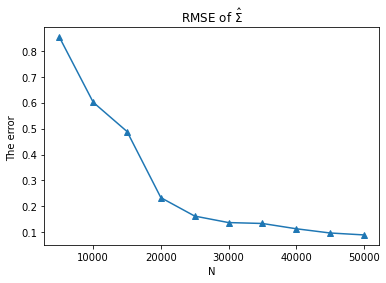

In [23]:
import matplotlib.pyplot as plt
plt.plot(n_lst,rmse_Sigma_lst,marker='^')
# plt.ylim(0,9)
# plt.xticks(range(4),n_lst)
plt.ylabel('The error ')
plt.title('RMSE of $\hat{\Sigma}$')
plt.xlabel('N')
# plt.xticks(range(4),n_lst)

plt.show()

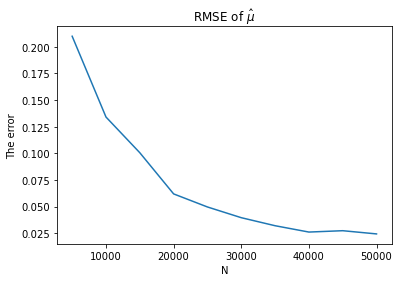

In [22]:
plt.plot(n_lst,rmse_mu_lst)
# plt.ylim(0,6)
plt.ylabel('The error')
plt.title('RMSE of $\hat{\mu}$')
plt.xlabel('N')
# plt.xticks(range(4),n_lst)
plt.show()